# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from funciones_analisis import detectar_drift_ks, _drift_blocks, plot_ks_gallery, plot_ks_one, plot_ks_counts, merge_blocks, plot_raw_with_drift, build_active_flag, blocks_from_flag, plot_with_active_blocks

# Lectura

In [2]:
# Leer los tres dataframes procesados desde la carpeta 'df_procesados'
df_planta_1 = pd.read_csv('../df_procesados/df_planta_1.csv')
df_planta_2 = pd.read_csv('../df_procesados/df_planta_2.csv')
df_planta_3 = pd.read_csv('../df_procesados/df_planta_3.csv')

In [3]:
df_planta_1['date_time'] = pd.to_datetime(df_planta_1['date_time'])
df_planta_2['date_time'] = pd.to_datetime(df_planta_2['date_time'])
df_planta_3['date_time'] = pd.to_datetime(df_planta_3['date_time'])

# Planta 1

In [4]:
res = detectar_drift_ks(
df_planta_1,
columnas=[c for c in df_planta_1.select_dtypes('number').columns],
window_days=1, step_days=1,    # <- una ventana por día
min_dias=1,  min_points=800,   # ajusta según tu frecuencia
compare="adjacent",
skip_first_days=2,
alpha=0.005, ks_min=0.15,
fdr=True, min_consecutive=2,
winsor=(0.01, 0.99)        # opcional
)

res

,variable,window_start,window_end,ref_start,ref_end,n_ref,n_new,stat,pvalue,drift_detectado,detalle
0,Conductividad DAF,2025-05-24,2025-05-24 23:59:59,2025-05-23,2025-05-23 23:59:59,1374,1333,0.000000,1.000000e+00,False,ok
1,Conductividad DAF,2025-05-25,2025-05-25 23:59:59,2025-05-24,2025-05-24 23:59:59,1333,1380,0.000000,1.000000e+00,False,ok
2,Conductividad DAF,2025-05-26,2025-05-26 23:59:59,2025-05-25,2025-05-25 23:59:59,1380,1379,0.000000,1.000000e+00,False,ok
3,Conductividad DAF,2025-05-27,2025-05-27 23:59:59,2025-05-26,2025-05-26 23:59:59,1379,1374,0.000000,1.000000e+00,False,ok
4,Conductividad DAF,2025-05-28,2025-05-28 23:59:59,2025-05-27,2025-05-27 23:59:59,1374,1377,0.000000,1.000000e+00,False,ok
...,...,...,...,...,...,...,...,...,...,...,...
868,pH salida y control Ecualizador 1,2025-08-05,2025-08-05 23:59:59,2025-08-04,2025-08-04 23:59:59,1187,1186,0.354648,7.224411e-67,True,ok
869,pH salida y control Ecualizador 1,2025-08-06,2025-08-06 23:59:59,2025-08-05,2025-08-05 23:59:59,1186,1192,0.451973,4.916315e-110,True,ok
870,pH salida y control Ecualizador 1,2025-08-07,2025-08-07 23:59:59,2025-08-06,2025-08-06 23:59:59,1192,1184,0.518320,4.387851e-146,True,ok
871,pH salida y control Ecualizador 1,2025-08-08,2025-08-08 23:59:59,2025-08-07,2025-08-07 23:59:59,1184,1192,0.519227,1.299431e-146,True,ok


In [8]:
res["drift_detectado"].value_counts()

drift_detectado
True     583
False    290
Name: count, dtype: int64

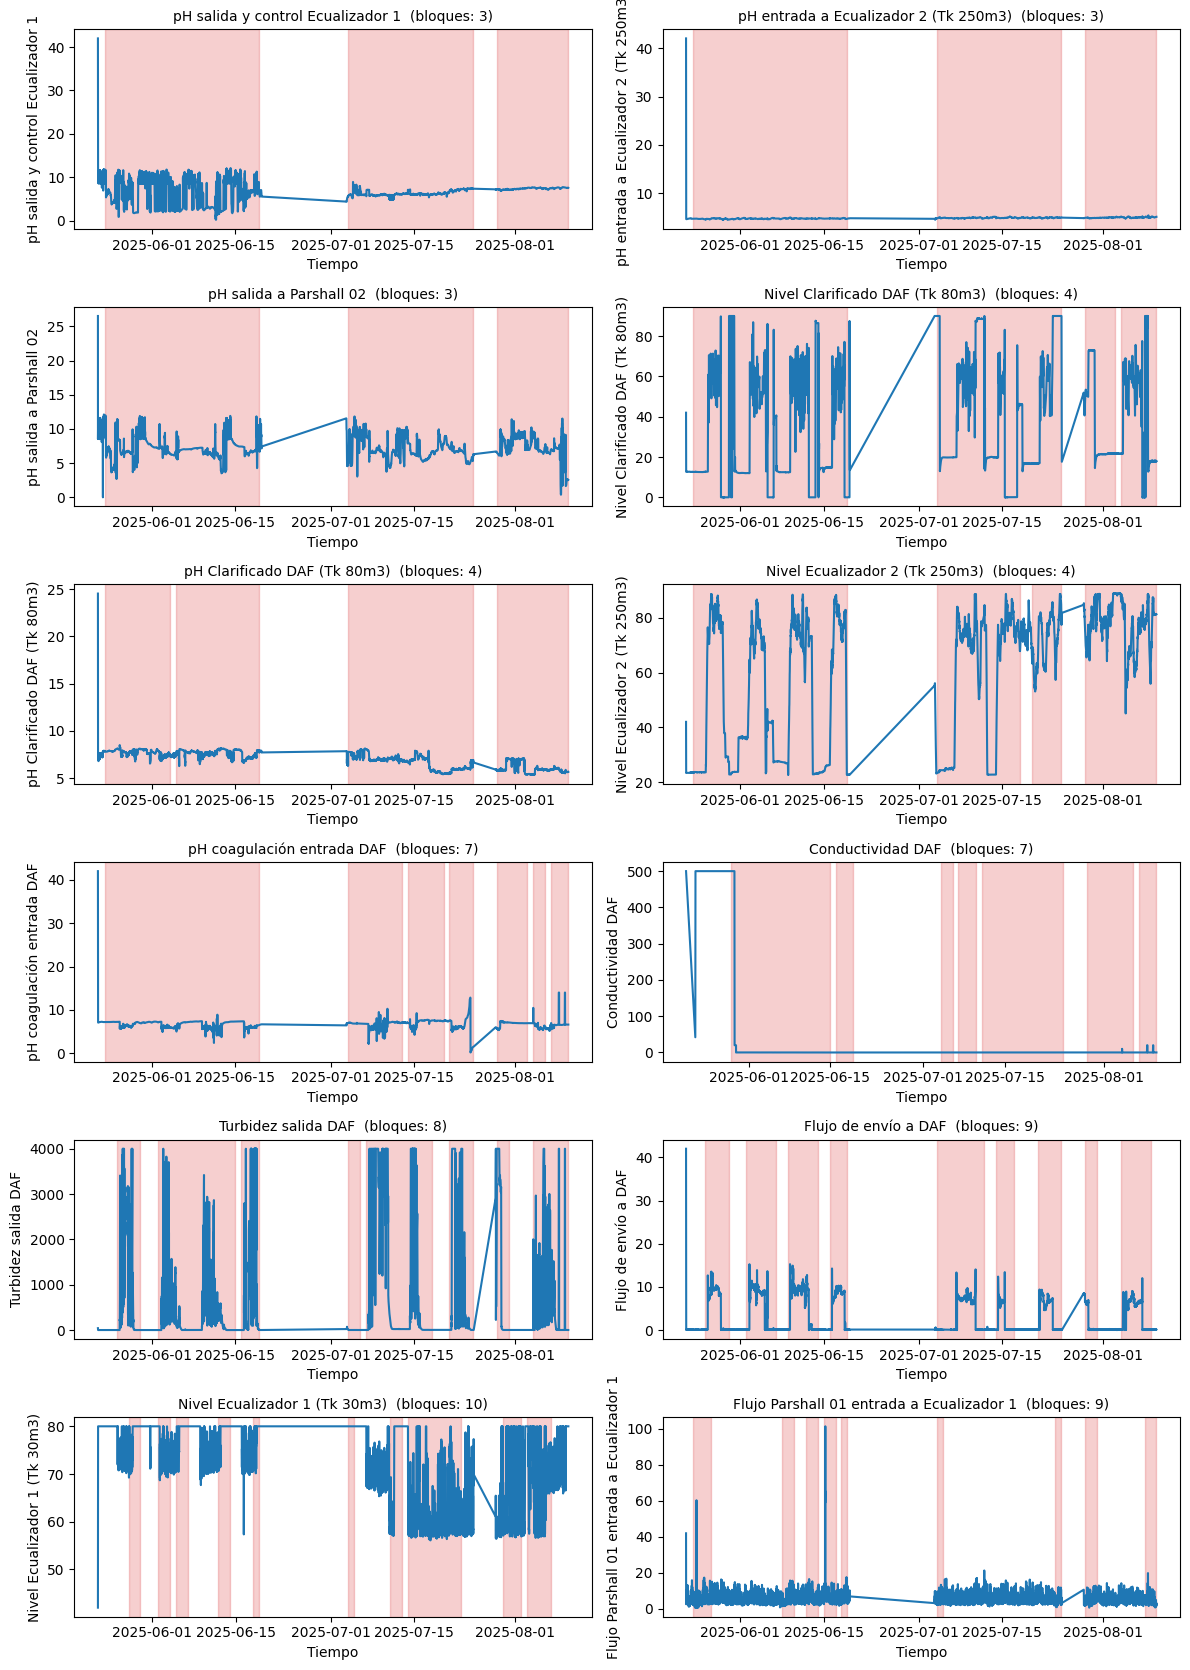

In [7]:
# 1) Galería de TODAS las variables que tienen drift
plot_ks_gallery(df_planta_1, res, "date_time", resample="10min", ncols=2, height_per_row=2.8, only_with_drift=True)

## Ventanas de Proceso Activo

c:\Users\frncc\OneDrive - Universidad Católica de Chile\Desktop\UC\2025-2\Proyecto de Grado\Proyecto-Grado\Analisis\funciones_analisis.py:682: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d = d.asfreq(freq)


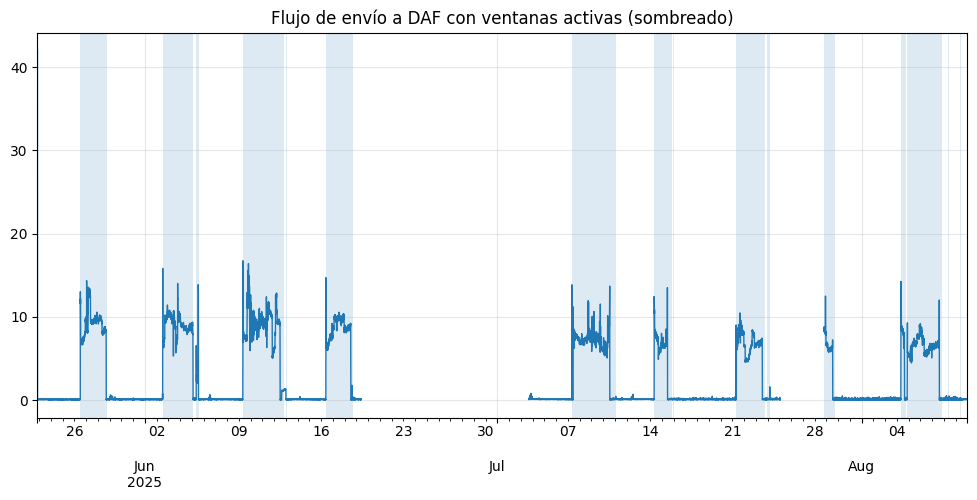

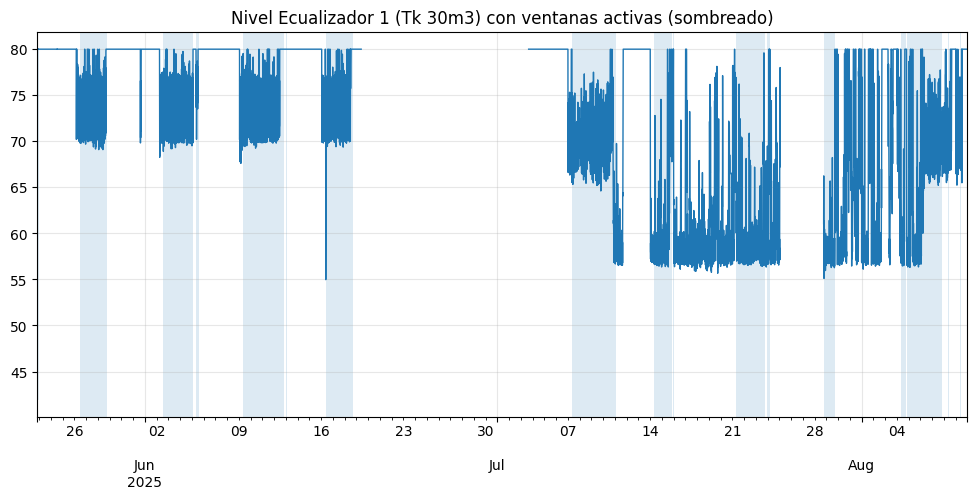

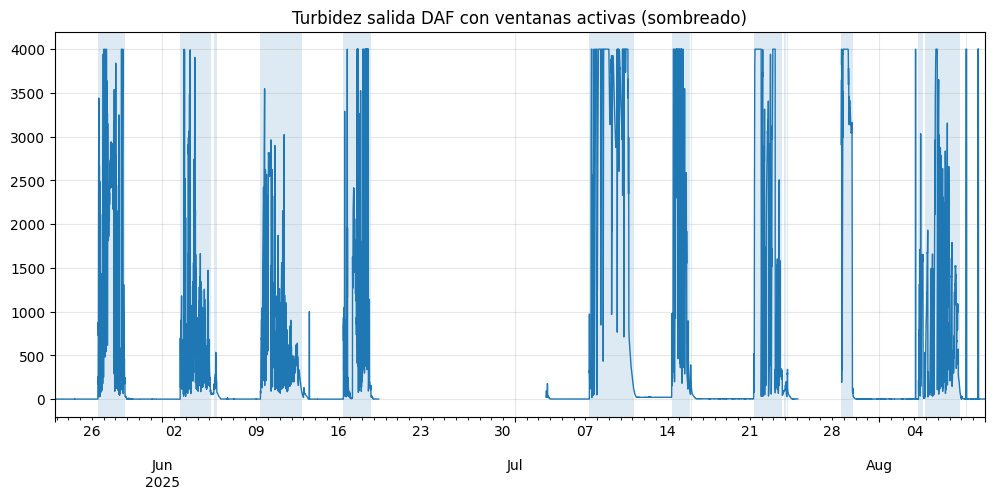

In [7]:
df = df_planta_1.copy()
df["date_time"] = pd.to_datetime(df["date_time"])

# Reglas de activación (OR entre reglas)
rules = {
    "Flujo de envío a DAF": {"op": ">", "thr": 2},
    "Turbidez salida DAF": {"op": ">", "thr": 100},
    "Nivel Ecualizador 2 (Tk 250m3)": {"op": "diff>", "thr": 1.0},  # movimiento
}

# Flag estable (closing + merge de gaps) y bloques
flag = build_active_flag(
    df, "date_time", rules,
    smooth_window=30,
    min_block_len=30,
    close_window=9,       # tapa microcortes ~9'
    max_gap_minutes=25,   # funde tramos separados por <=25'
    edge_buffer=3         # opcional: expande 3' por lado
)

blocks_activos = blocks_from_flag(df, "date_time", flag)

# Ver rápidamente si marca bien en 3 variables clave:
for col in [
    "Flujo de envío a DAF",
    "Nivel Ecualizador 1 (Tk 30m3)",
    "Turbidez salida DAF",
]:
    plot_with_active_blocks(df, "date_time", col, blocks_activos, resample="5min")

# Planta 2

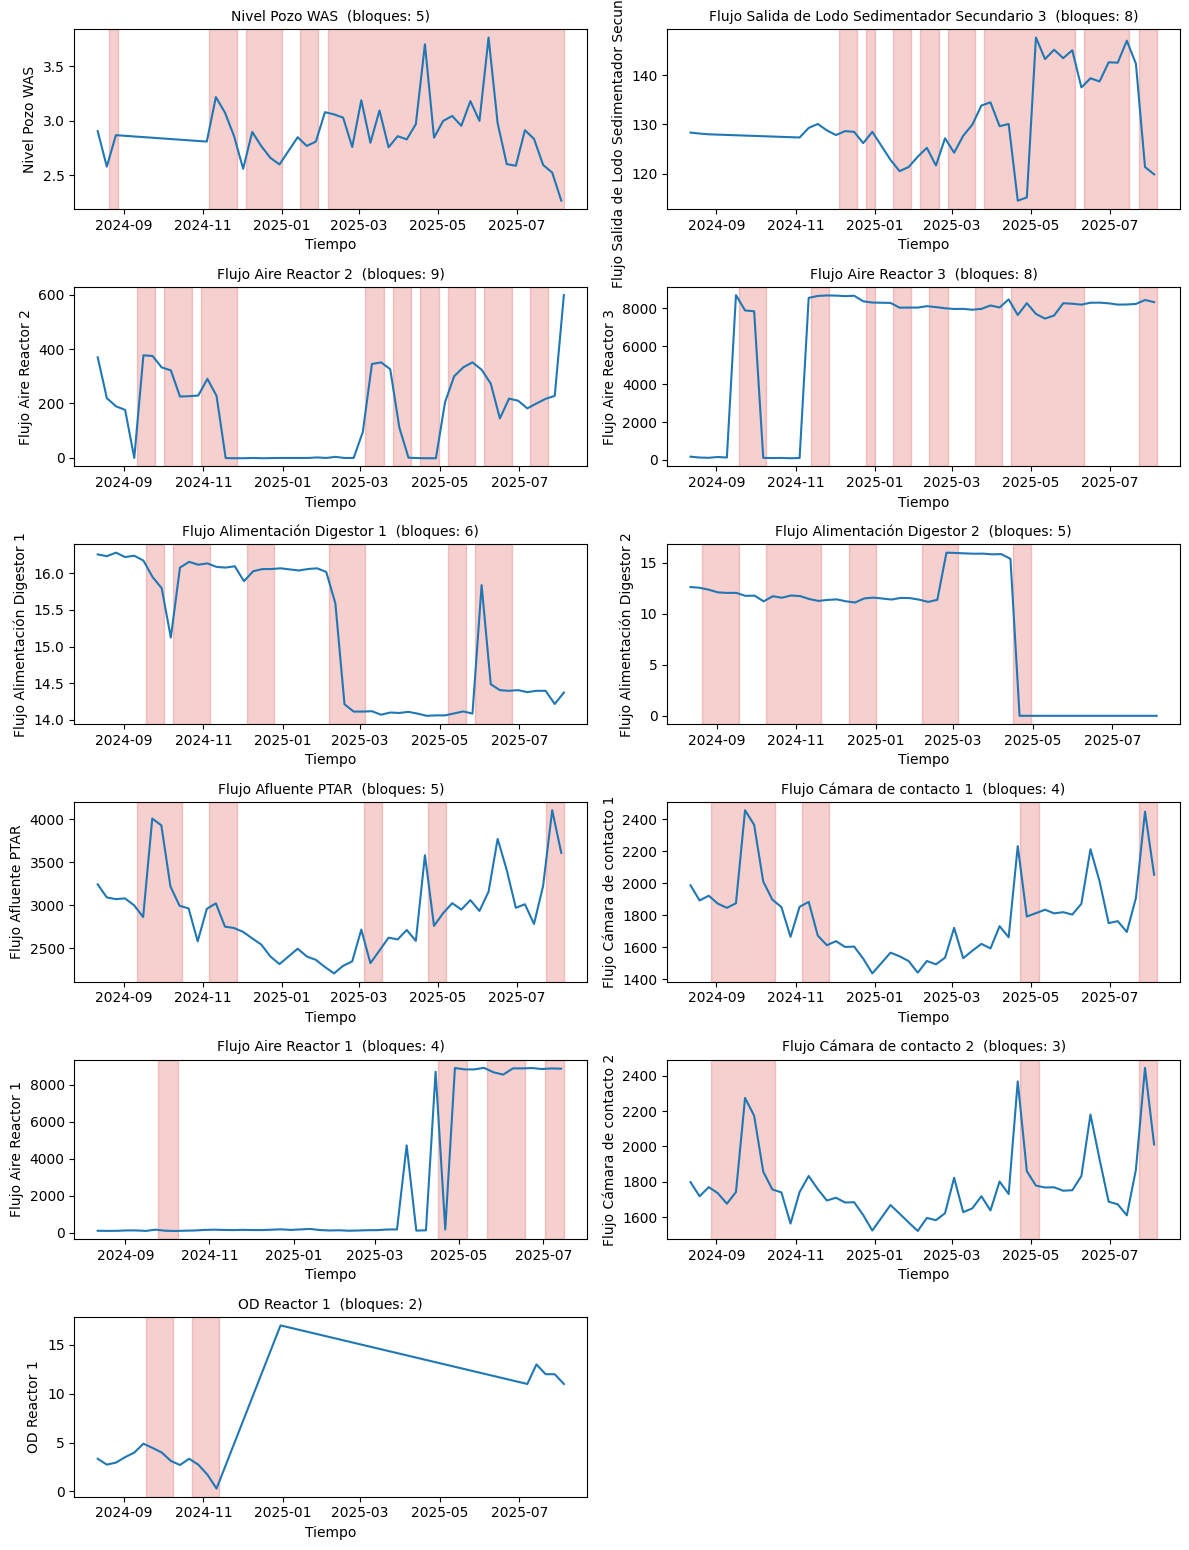

In [10]:
cols2 = df_planta_2.select_dtypes('number').columns.tolist()

res2 = detectar_drift_ks(
    df_planta_2, columnas=cols2,
    window_days=7, step_days=7,   # semanal, sin solape
    min_dias=5, min_points=1200,  # ~200 pts/día * 5 días
    compare="adjacent",
    skip_first_days=2,
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=2,
    winsor=(0.01, 0.99)
)

# visual semanal
plot_ks_gallery(df_planta_2, res2, "date_time", resample="7D", ncols=2)


# Planta 3

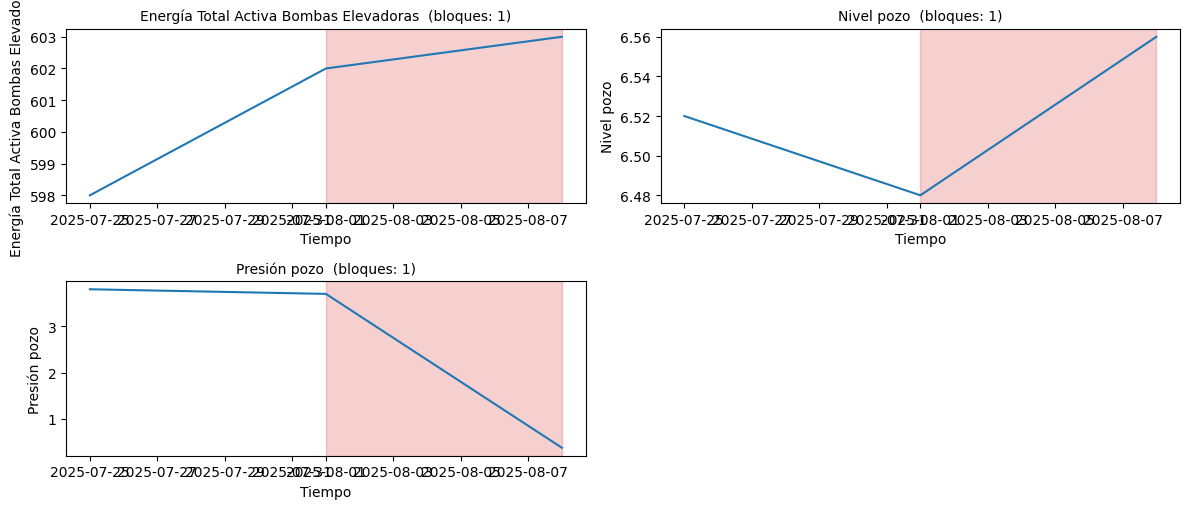

In [11]:
cols3 = df_planta_3.select_dtypes('number').columns.tolist()

res3 = detectar_drift_ks(
    df_planta_3, columnas=cols3,
    window_days=7, step_days=7,
    min_dias=5, min_points=7000,  # ~1.4k pts/día * 5 días ≈ 7k
    compare="adjacent",
    skip_first_days=1,            # evita sesgo del arranque sin perder ventanas
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=1,  # clave por horizonte corto
    winsor=(0.01, 0.99)
)

plot_ks_gallery(df_planta_3, res3, "date_time", resample="7D", ncols=2)
